# A Practice on "MovieLens 100K Dataset": #4: Matrix Factorization with Alternating Least Squares (ALS)

Previously, I showed how to use similarity-based approaches that guess unknown user-movie-rating triplets by looking at either movies with a similar rating profile or users with a similar rating profile. These approaches leave a lot of data on the table though. Matrix factorization is a way to both take into account more data and perform some regularizing dimensionality reduction to help deal with the sparsity problem.

The basic idea is to organize the user-movie-rating triplets into a matrix with each row representing a user and each column representing a movie. We want to approximate this large matrix with a matrix multiplication of 2 smaller matrices. In the example below, each row of the "User Matrix" has 2 latent features of that user, and each column of the "Item Matrix" has 2 latent features of that item. The dot product of any user's latent features and item's latent features will give an estimate of the rating that user would give that movie.

![Matrix Factorization Example](https://github.com/benlindsay/movielens-analysis/blob/master/images/matrix-factorization.png?raw=1)

Image Source: [https://medium.com/@connectwithghosh](https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536)

There are many variations on this theme and multiple ways to perform this matrix factorization. The method I demonstrate here is called "Alternating Least Squares" method which was designed for the [Netflix Prize](https://www.netflixprize.com/) and described in [this paper](http://www.grappa.univ-lille3.fr/~mary/cours/stats/centrale/reco/paper/MatrixFactorizationALS.pdf). This method works iteratively, with 2 main steps per iteration:

1. Assume the User Matrix is fixed and solve for the Item Matrix
2. Assume the Item Matrix is fixed and solve for the User Matrix




# 0. Mount and load raw data

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
cd /gdrive/MyDrive/Lectures/2024/RecSys

/gdrive/MyDrive/Lectures/2024/RecSys


# 1. Import necessary modules and classes

In [ ]:
# <!-- collapse=True -->
%matplotlib inline
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

# Import User + Movie baseline model
from cf_utils import DampedUserMovieBaselineModel

# Use custom matplotlib stylesheet
plt.style.use('seaborn-darkgrid')

<ipython-input-5-e72051cea4ab>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


# 2. Load the Data

Let's load and examine the ratings data. If you're following along (i.e. actually running these notebooks) you'll need to make sure to run the first one to download the data before running this one.

In [ ]:
# <!-- collapse=True -->
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep='\t', header=None,
                         names=['userId', 'movieId', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)
ratings_df = ratings_df.sort_values('timestamp')
print('First 5:')
display(ratings_df.head())
print()
print('Last 5:')
display(ratings_df.tail())

First 5:


,userId,movieId,rating,timestamp
214,259,255,4,1997-09-20 03:05:10
83965,259,286,4,1997-09-20 03:05:27
43027,259,298,4,1997-09-20 03:05:54
21396,259,185,4,1997-09-20 03:06:21
82655,259,173,4,1997-09-20 03:07:23



Last 5:


,userId,movieId,rating,timestamp
46773,729,689,4,1998-04-22 23:10:38
73008,729,313,3,1998-04-22 23:10:38
46574,729,328,3,1998-04-22 23:10:38
64312,729,748,4,1998-04-22 23:10:38
79208,729,272,4,1998-04-22 23:10:38


# 3. Write helper function and ALSRecommender class

In [ ]:
# <!-- collapse=True -->
def get_rating_matrix(X):
    """Function to generate a ratings matrx and mappings for
    the user and item ids to the row and column indices

    Parameters
    ----------
    X : pandas.DataFrame, shape=(n_ratings,>=3)
        First 3 columns must be in order of user, item, rating.

    Returns
    -------
    rating_matrix : 2d numpy array, shape=(n_users, n_items)
    user_map : pandas Series, shape=(n_users,)
        Mapping from the original user id to an integer in the range [0,n_users)
    item_map : pandas Series, shape=(n_items,)
        Mapping from the original item id to an integer in the range [0,n_items)
    """
    user_col, item_col, rating_col = X.columns[:3]
    rating = X[rating_col]
    user_map = pd.Series( #user 번호를 index로 매핑하는 역할 -> 1을 0으로 변환
        index=np.unique(X[user_col]),
        data=np.arange(X[user_col].nunique()),
        name='user_map',
    )
    item_map = pd.Series(
        index=np.unique(X[item_col]),
        data=np.arange(X[item_col].nunique()),
        name='columns_map',
    )
    user_inds = X[user_col].map(user_map)
    item_inds = X[item_col].map(item_map)
    rating_matrix = (
        pd.pivot_table( #pivot table을 거치면 rating matrix를 얻을 수 있음
            data=X,
            values=rating_col,
            index=user_inds,
            columns=item_inds,
        )
        .fillna(0)
        .values
    )
    return rating_matrix, user_map, item_map

- 예제 데이터 프레임 (rating_df)에서 평점 행렬 생성
- user map & item_map : 사용자 ID와 item ID를 Index로 매핑하는 역할
- rating matrix : pivot_table은 3개의 순서쌍을 rating matrix로 변경해주는 역할

In [ ]:
a,b,c = get_rating_matrix(ratings_df)

- 평점 행렬의 크기 출력

In [ ]:
a.shape

(943, 1682)

- 평점 행렬의 각 행에 대해 출력
- 평점 행렬의 각 행에 대해 반복하여, 해당 행과 그 행의 비어있지 않은 요소의 인덱스를 출력

In [ ]:
for i, Ri in enumerate(a):
  print(i, Ri, Ri.shape)
  print( np.nonzero(Ri) )
  break

0 [5. 3. 4. ... 0. 0. 0.] (1682,)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 17

## NumPy를 사용하여 행렬 연산을 수행하는 예제

###초기화 및 형태 확인
- V 행렬을 5X2 크기의 모든 요소가 1인 행렬로 초기화

In [ ]:
V = np.ones((5,2))

- V 행렬의 1,2,3,4 번째 행을 선택하여 V_Ri로 초기화
- Ri_nonzero 배열을 1, 2, 3, 4로 초기화

In [ ]:
V_Ri = V[[1,2,3,4],:]
Ri_nonzero=np.array([1,2,3,4])

- V_Ri와 Ri_nonzero의 형태 확인


In [ ]:
V_Ri.shape, Ri_nonzero.shape

((4, 2), (4,))

- Ri_nonzero와 V_Ri의 행렬 곱셈
- @ 와 np.dot은 행렬 곱셈을 수행하는 역할 (둘 다 같은 결과 출력)

In [ ]:
Ri_nonzero @ V_Ri, np.dot(Ri_nonzero, V_Ri)

(array([10., 10.]), array([10., 10.]))

In [ ]:
# <!-- collapse=True -->
class ALSRecommender():
    """Recommender based on Alternating Least Squares algorithm.

    Parameters
    ----------
    k : int, default=5
        hidden space dimension
    lmbda : float, default=0.1
        정규화 파라미터
    max_epochs : int, default=15
        최대 반복 횟수
    baseline_algo : object
        fit(X)와 predict(X) 메서드를 가진 객체
    """
    def __init__(self, k=5, lmbda=0.1, max_epochs=15, baseline_algo=None, error_metric='mae',
                 verbose=True):
        # Force integer in case it comes in as float
        self.k = int(np.round(k)) # hidden_space 의 수
        self.lmbda = lmbda   # lmbda : 정규화 파라미터
        self.max_epochs = max_epochs  # max_epochs : 최대 반복 횟수
        self.baseline_algo = baseline_algo  # baseline_algo : 기본 예측 알고리즘
        self.error_metric = error_metric # error_metric : 오류 측정 지표 MAE
        self.verbose = verbose # verbsoe : 학습 중 출력 여부

        self.U = None # 사용자 특성 행렬
        self.V = None # 아이템 특성 행렬
        self.initialized = False # 초기화 여부

    #학습 오류 계산 메서드
    #U와 V 행렬을 사용하여 예측 평점 행렬 R_hat을 계산하고, 실제 평점 행렬 R과 비교하여 MAE를 계산
    def _calc_train_error(self, U, V, R, R_selector=None, error_metric='mae'):
        if R_selector is None:
            R_selector = (R > 0) # 평점이 있는 요소 선택
        R_hat = U @ V.T # 예측 평점 행렬 계산
        if error_metric == 'mae':
            error = np.sum(R_selector * np.abs(R_hat - R)) / np.sum(R_selector) # MAE 계산
        else:
            raise ValueError("{} is an unsupported error metric".format(error_metric))
        return error

    #학습 초기화 함수
    #X 데이터프레임을 사용하여 초기화 작업을 수행
    # 사용자-아이템 평점 행렬 R을 생성하고, U와 V 행렬을 초기화
    def _fit_init(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col, rating_col = X.columns[:3]
        if self.baseline_algo is None:
            self.train_mean = X[rating_col].mean() # 기본 예측값 설정
        else:
            self.baseline_algo.fit(X)   # baseline 알고리즘 학습
        self.R, self.user_map, self.item_map = get_rating_matrix(X)   # 평점 행렬 생성
        n_users, n_items = self.R.shape   # 사용자 및 아이템 수
        # self.U = 3 * np.random.rand(self.k, size=(n_users, self.k))
        # self.V = 3 * np.random.rand(self.k, size=(n_items, self.k))
        self.U = 3*np.random.rand(n_users, self.k) # 사용자 특성 행렬 초기화
        self.V = 3*np.random.rand(n_items, self.k) # 아이템 특성 행렬 초기화
        self.V[:, 0] = self.R[self.R != 0].mean(axis=0) # 첫 번째 열은 각 아이템의 평균 평점으로 초기화
        self.E = np.eye(self.k) # (k x k)-dimensional idendity matrix = (k x k) 단위 행렬
        self.epoch = 0 # 에포크 초기화
        self.train_errors = []
        self.initialized = True # 초기화 완료

    #학습 함수
    #ALS 알고리즘을 사용하여 U와 V 행렬을 반복적으로 업데이트합니다.
    # 각 에포크마다 학습 오류를 계산하고 저장
    def fit(self, X, n_epochs=None):
        """Fit model to training data X. If at least one iteration has already been run,
        then the model will continue from its most recent state.

        Parameters
        ----------
        X : pandas DataFrame, shape=(n_ratings, >=3)
            First 3 columns must correspond to user, item, and rating in that order
        n_epochs : int, optional
            Number of iterations to run. If not provided, will run for self.max_epochs

        Returns
        -------
        self
            This allows chaining like `ALSRecommender().fit(X_train).predict(X_test)`
        """
        # Allow continuation from previous state if n_epochs is given. Otherwise start from scratch.
        if n_epochs is None:
            self.initialized = False # 초기화 상태
        if not self.initialized:
            self._fit_init(X) # 초기화

        epoch_0 = self.epoch
        if n_epochs is None:
            n_epochs = self.max_epochs - epoch_0

        n_users, n_items = self.R.shape

        # Run n_epochs iterations
        for i_epoch in range(n_epochs): #n_epochs 수만큼 반복 n_epochs = 15
            if self.epoch >= self.max_epochs:
                print("max_epochs = {}".format(self.max_epochs))
                break
            # V를 상수 취급하고 U를 평가하고 update함 -> U의 i번째 행을 업데이트하기 위해
            for i, Ri in enumerate(self.R): #평점행렬 각 행별로 update 진행시킴 (943번 반복)
                nui = np.count_nonzero(Ri)  # 사용자가 평가한 아이템 수
                if (nui == 0): nui = 1 # Be aware of zero counts!
                # 평점이 있는 요소 선택
                Ri_nonzero_selector = np.nonzero(Ri)[0]
                # Select subset of V associated with movies reviewed by user i
                V_Ri = self.V[Ri_nonzero_selector, :] # shape=(n', k)
                # Select subset of row R_i associated with movies reviewed by user i
                Ri_nonzero = self.R[i, Ri_nonzero_selector] # shape=(n', )
                Ai = V_Ri.T @ V_Ri + self.lmbda * nui * self.E # shape=(k, k)
                # print('nui', nui, end='')
                Vi = Ri_nonzero @ V_Ri # shape=(k, )
                # print('UU', Ai.shape, Vi.shape)
                self.U[i, :] = np.linalg.solve(Ai, Vi) # U 행렬 업데이트


            # U를 고정시키고 V를 평가하고 update함
            for j, Rj in enumerate(self.R.T): # 1683번 반복
                nmj = np.count_nonzero(Rj) # 아이템을 평가한 사용자 수
                if (nmj == 0): nmj = 1 # Be aware of zero counts!
                # Get array of nonzero indices in row Ij
                Rj_nonzero_selector = np.nonzero(Rj)[0]
                # Select subset of P associated with users who reviewed movie j
                U_Rj = self.U[Rj_nonzero_selector, :] # shape=(m', k)
                # Select subset of column R_j associated with users who reviewed movie j
                Rj_nonzero = self.R[Rj_nonzero_selector, j] # shape=(m', )
                Aj = U_Rj.T @ U_Rj + self.lmbda * nmj * self.E
                # print('nmj', nmj, Rj_nonzero.shape, end='')
                Uj = Rj_nonzero @ U_Rj
                # print('VV', Aj.shape, Uj.shape)
                self.V[j, :] = np.linalg.solve(Aj, Uj) # V 행렬 업데이트
            error = self._calc_train_error(self.U, self.V, self.R)
            self.train_errors.append(error) # 학습 오류 기록
            if self.verbose:
                print("[Epoch {}/{}] train error: {}".format(self.epoch, self.max_epochs, error))
            self.epoch += 1
        return self

    #예측 함수
    #사용자-아이템 쌍에 대한 평점을 예측합니다.
    #U와 V 행렬을 사용하여 평점을 계산하고, 알려진 사용자-아이템 쌍에 대해 예측합니다.
    def predict(self, X):
        """Generate predictions for user/item pairs

        Parameters
        ----------
        X : pandas dataframe, shape = (n_pairs, 2)
            User, item dataframe

        Returns
        -------
        rating_pred : 1d numpy array, shape = (n_pairs,)
            각 사용자/아이템 쌍에 대한 평점 예측 배열
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        user_col, item_col = X.columns[:2]
        # 베이스라인 알고리즘이 없으면 전체 평균 평점 사용
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean #기본 예측값 설정 -> 평균평점
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        X['rating'] = 0
        # 사용자와 아이템이 모두 매핑된 경우 필터링 - 매핑된 경우와 아닌 경우 나누기
        known_user_and_item_mask = (
            X[user_col].isin(self.user_map.index) & X[item_col].isin(self.item_map.index)
        )
        X_known, X_unknown = X[known_user_and_item_mask], X[~known_user_and_item_mask]

        #사용자와 아이템 인덱스 매핑
        user_inds = X_known[user_col].map(self.user_map)
        item_inds = X_known[item_col].map(self.item_map)
        rating_pred = np.array([
            np.sum(self.U[u_ind, :] * self.V[i_ind, :])
            for u_ind, i_ind in zip(user_inds, item_inds)
        ])
        # 알려진 사용자-아이템 쌍에 대해 잠재요인 곱을 통해 평점 예측
        X.loc[known_user_and_item_mask, 'rating'] = rating_pred

        # 베이스라인 알고리즘을 사용하여 알려지지 않은 사용자-아이템 쌍에 대한 예측
        X.loc[~known_user_and_item_mask, 'rating'] = self.baseline_algo.predict(X_unknown)

        # 평점의 최솟값과 최댓값 설정
        min_rating = np.min(self.R[np.nonzero(self.R)])
        max_rating = np.max(self.R)
        X.loc[X['rating'] < min_rating, 'rating'] = min_rating
        X.loc[X['rating'] > max_rating, 'rating'] = max_rating
        return X['rating'].values # 예측된 평점을 1차원 numpy 배열로 반환

##np.linalg.solve() 메소드

np.linalg.solve(A, B) 는 다음과 같은 선형 시스템을 푼다.

$A⋅X=B$

# 4. Determine how many epochs are necessary
- K-Fold 교차 검증을 사용하여 ALS 기반 추천 시스템의 성능을 평가

- 폴드에서 모델을 학습하고 테스트하여 MAE를 계산하고, 학습 및 테스트 오류를 기록

- 총 학습 수 = n_split * max_epochs = 250

In [ ]:
# <!-- collapse=True -->
# %%time
n_splits = 5 # 교차 검증에서의 폴드 수
max_epochs = 50 # 최대 에포크 수
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True) # K-Fold 교차 검증 객체 생성
train_errs = np.zeros((n_splits, max_epochs)) # 학습 오류를 저장할 배열
test_errs = np.zeros((n_splits, max_epochs)) # 테스트 오류를 저장할 배열
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)): #데이터프레임을 교차검증 폴드로 분할
    print("i_fold={}".format(i_fold)) #몇 번째 폴드인지 출력
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds] #현재 폴드의 학습 및 테스트 데이터 저장
    # train_df, test_df = ratings_df, ratings_df
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10) #기본 예측 알고리즘 설정 ->Damped모델
    rec = ALSRecommender(k=20, baseline_algo=baseline_algo, verbose=False, max_epochs=max_epochs) #ALS 알고리즘 객체 생성
    for i_epoch in range(max_epochs):
        rec.fit(train_df, n_epochs=1) #학습데이터로 1 epoch 동안 학습
        preds = rec.predict(test_df[['userId', 'movieId']]) # 테스트 데이터에 대해 평점 예측
        test_err = mean_absolute_error(preds, test_df['rating']) #MAE 게산
        print("[Epoch {}/{}] test MAE: {}".format(i_epoch, max_epochs, test_err))
        # break
        test_errs[i_fold, i_epoch] = test_err
    train_errs[i_fold, :] = np.array(rec.train_errors) #배열로 학습 오류 저장
    # break

print(f"There are {len(rec.user_map)} users and {len(rec.item_map)} items")

i_fold=0
[Epoch 0/50] test MAE: 1.0415993054869606
[Epoch 1/50] test MAE: 0.8539471804125511
[Epoch 2/50] test MAE: 0.8095712907264071
[Epoch 3/50] test MAE: 0.7865870137238766
[Epoch 4/50] test MAE: 0.7720545344079133
[Epoch 5/50] test MAE: 0.7621290689611265
[Epoch 6/50] test MAE: 0.7549188256291302
[Epoch 7/50] test MAE: 0.7495432897542059
[Epoch 8/50] test MAE: 0.7453663452598108
[Epoch 9/50] test MAE: 0.7421347334926995
[Epoch 10/50] test MAE: 0.7395352717940478
[Epoch 11/50] test MAE: 0.7374290725905954
[Epoch 12/50] test MAE: 0.7357137133887609
[Epoch 13/50] test MAE: 0.7342856765333048
[Epoch 14/50] test MAE: 0.7331123853451887
[Epoch 15/50] test MAE: 0.7321204093453256
[Epoch 16/50] test MAE: 0.7312845548375132
[Epoch 17/50] test MAE: 0.7305718165648264
[Epoch 18/50] test MAE: 0.7299723976309529
[Epoch 19/50] test MAE: 0.7294512344635216
[Epoch 20/50] test MAE: 0.7290104102031584
[Epoch 21/50] test MAE: 0.7286262748728681
[Epoch 22/50] test MAE: 0.7283046158718778
[Epoch 23/50



##오류 계산 및 시각화

- 학습과 테스트 과정에서의 MAE (Mean Absolute Error) 변화를 시각화
- 각 에포크마다의 평균 오류와 표준 편차를 계산하여 그래프로 표현

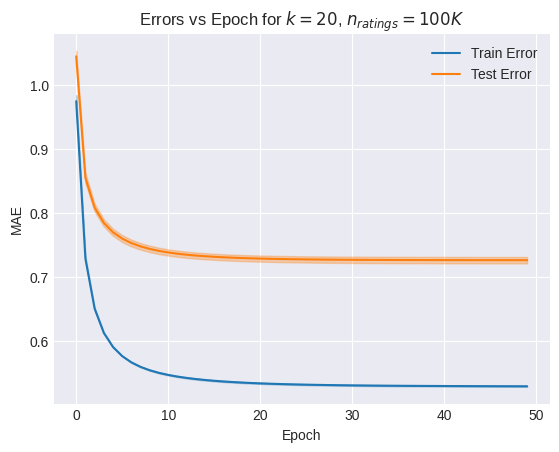

In [ ]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
# 평균 ± 표준 편차 영역을 색칠하여 그래프에 신뢰 구간을 추가 - 학습 오류 그래프
l, = plt.plot(np.arange(max_epochs), train_avg, label='Train Error')
plt.fill_between(np.arange(max_epochs), train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
# 평균 ± 표준 편차 영역을 색칠하여 그래프에 신뢰 구간을 추가 - 테스트 오류 그래프
l, = plt.plot(np.arange(max_epochs), test_avg, label='Test Error')
plt.fill_between(np.arange(max_epochs), test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title(r'Errors vs Epoch for $k=20$, $n_{ratings}=100K$')
plt.show()

- 그래프를 통해 테스트 오류가 15에서 20 에포크 사이에서 안정화되는 것을 확인
- 이를 통해 모델이 이 에포크 이후에는 더 이상 성능이 크게 향상되지 않는다는 것을 알 수 있다.

# 5. Find Optimal $k$

In [ ]:
n_splits = 5 # K-Fold 교차 검증의 폴드 수
max_epochs = 15 # 각 폴드에서 최대 학습 에포크 수
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True) # K-Fold 교차 검증 객체 생성
k_list = [1, 2, 5, 10, 20, 50, 100] # 테스트할 잠재적 특성 수 (k 값)
small_df = ratings_df.iloc[:100000] # 데이터프레임의 일부분을 사용
train_errs = np.zeros((n_splits, len(k_list))) # 학습 오류를 저장할 배열
test_errs = np.zeros((n_splits, len(k_list))) # 테스트 오류를 저장할 배열
for i_fold, (train_inds, test_inds) in enumerate(kf.split(small_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = ALSRecommender(k=k, baseline_algo=baseline_algo, verbose=False, max_epochs=max_epochs)
        rec.fit(train_df)
        preds = rec.predict(test_df[['userId', 'movieId']])
        test_err = mean_absolute_error(preds, test_df['rating'])
        test_errs[i_fold, i_k] = test_err
        train_errs[i_fold, i_k] = rec.train_errors[-1]
    print()

i_fold=0: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=1: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=2: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=3: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=4: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 


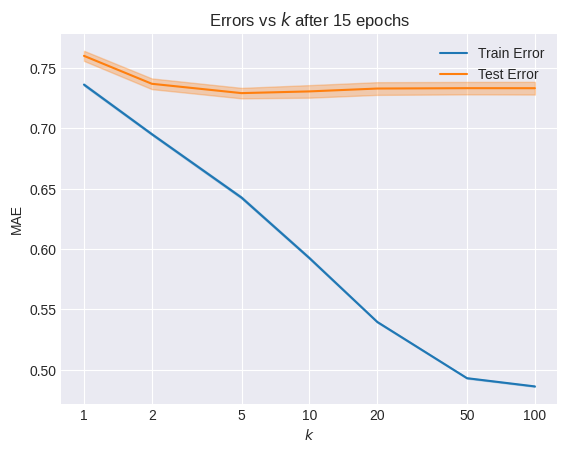

In [ ]:
train_avg, train_std = train_errs.mean(axis=0), train_errs.std(axis=0)
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.semilogx(k_list, train_avg, label='Train Error')
plt.fill_between(k_list, train_avg-train_std, train_avg+train_std,
                 color=l.get_color(), alpha=0.3)
l, = plt.semilogx(k_list, test_avg, label='Test Error')
plt.fill_between(k_list, test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.xticks(k_list, k_list)
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel('MAE')
plt.title(r'Errors vs $k$ after {} epochs'.format(max_epochs))
plt.show()

It looks like we have a Test Error minimum around $k=10$, although since $k=5$ is so close, I would go with that since it is likely to generalize better.

Check out the next notebook where I explore Stochastic Gradient Descent!

# Explore Results: Item Matrix
- ALS 알고리즘 수행 후에 미지의 아이템 평점 행렬이 다시 복원됨

- 분해된 U 행렬과 V 행렬을 가지고 추가적인 유사도 측정이 가능

- **그 중 분해된 아이템 행렬인 V 행렬을 가지고 부가적인 작업 수행할 것**


In [ ]:
train_df = pd.read_csv('raw/ml-100k/u1.base', sep='\t', header=None, #80 : 20 = train : test Dataset으로 나눔
                       #u1~u5까지 존재 (마치 k-fold cross validation 처럼 데이터를 5등분 해높은 것)
                         names=['userId', 'movieId', 'rating', 'timestamp'])
train_df['timestamp'] = train_df['timestamp'].apply(datetime.fromtimestamp)
train_df = train_df.sort_values('timestamp')
test_df = pd.read_csv('raw/ml-100k/u1.test', sep='\t', header=None,
                         names=['userId', 'movieId', 'rating', 'timestamp'])
test_df['timestamp'] = test_df['timestamp'].apply(datetime.fromtimestamp)
test_df = test_df.sort_values('timestamp')

In [ ]:
baseline_algo = DampedUserMovieBaselineModel(damping_factor=10)
#ALSRecommender 수행 , k = 10 (optimal한 값) -> hidden space의 dimension
rec = ALSRecommender(k=10, baseline_algo=baseline_algo, verbose=False, max_epochs=15)
rec.fit(train_df)
preds = rec.predict(test_df[['userId', 'movieId']])
test_err = mean_absolute_error(preds, test_df['rating'])


여기까지가 정석적인 과정

---


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

- Factorize 결과인 item 행렬 V (1650, 10) 10차원의 벡터로 표현을 얻은 것

  (전체 item 개수 : 1682개 이지만 test에 참여하지 않은 데이터가 존재 -> 1650개)
  
- 코사인 유사도를 이용해서 item 끼리의 유사도 측정을 진행

In [ ]:
item_similarity_matrix = cosine_similarity(rec.V)
np.fill_diagonal(item_similarity_matrix, -1)
#자기 자신에 대한 유사도는 재지 않기 위해 -1 처리
knn_indices = np.argsort(item_similarity_matrix, axis=1)[:, ::-1][:, :10]
#행 기준으로 점수를 내림차순으로 정렬시키고 상위 10개 item index 모으기
#knn_indices -> item 번호가 아닌 item index로 구성됨
sample_range = np.arange(len(knn_indices))[:, None]
#상위 10개의 유사한 item의 유사도
knn_similarities = item_similarity_matrix[sample_range, knn_indices]

###상위 10개의 유사한 item의 이름을 가져올 때

- item_map = item 번호를 index 0번부터 mapping

- index로 매핑된 item 번호를 다시 가져오기 위해 0번의 index를 번호 1로 변환해줌


In [ ]:
#index로 매핑된 item을 item 번호로 변환
itemidx_to_itemno = pd.Series(rec.item_map.index, index=rec.item_map.values)

In [ ]:
item_info_df = pd.read_csv('raw/ml-100k/u.item', encoding_errors='replace', sep='|', header=None)[[0,1,2]]
item_info_df.columns = ['item_no', 'title', 'release_dt']
itemno_info_df = item_info_df.set_index('item_no')

In [ ]:
i = 226

- 영화 227번과 가장 유사한 영화 10개 고르기

In [ ]:
itemno_info_df.loc[[itemidx_to_itemno[i]] + list(itemidx_to_itemno[knn_indices[i]])]

,title,release_dt
item_no,,
227,Star Trek VI: The Undiscovered Country (1991),01-Jan-1991
230,Star Trek IV: The Voyage Home (1986),01-Jan-1986
228,Star Trek: The Wrath of Khan (1982),01-Jan-1982
429,"Day the Earth Stood Still, The (1951)",01-Jan-1951
229,Star Trek III: The Search for Spock (1984),01-Jan-1984
380,Star Trek: Generations (1994),01-Jan-1994
1269,Love in the Afternoon (1957),01-Jan-1957
1483,"Man in the Iron Mask, The (1998)",17-Mar-1998
755,Jumanji (1995),01-Jan-1995
